<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN/CNN_Bund10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.46 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 20:36:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Bund10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [ ]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 5.3MB/s 
     |████████████████████████████████| 143kB 56.4MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 174kB 59.8MB/s 
     |████████████████████████████████| 143kB 61.4MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['selu', 'relu']
        }
    }
}

In [ ]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Conv1D(filters=128, kernel_size=2, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Conv1D(filters=64, kernel_size=2, activation=config.activation))
    # layer 3
    model.add(MaxPooling1D(pool_size=2))
    # layer 4
    model.add(Flatten())
    # layer 5
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: yby3hon0
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN/sweeps/yby3hon0


In [ ]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: piejqii3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
32/32 [==============================] - 28s 23ms/step - loss: 0.1403 - mean_squared_error: 0.1403 - mean_absolute_error: 0.2179 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1299
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0384 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0652
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0615 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0661
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 9.0679e-04 - mean_squared_error: 9.0679e-04 - mean_absolute_error: 0.0236 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0560
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 7.1024e-04 - mean

wandb: Agent Starting Run: z2rzeyej with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 13ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1095 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0921
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0431 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0927
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0638 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0892
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0549 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1122
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0048 - mean_squared_erro

wandb: Agent Starting Run: aoha99l3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 15ms/step - loss: 0.1104 - mean_squared_error: 0.1104 - mean_absolute_error: 0.2578 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1340
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0430 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1266
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0373 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1219
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0339 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1199
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.

wandb: Agent Starting Run: 2kj5p4j4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 49ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1454 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1125
Epoch 2/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0473 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1203
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0548 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1396
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0624 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0979
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 

wandb: Agent Starting Run: tr640in1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 25ms/step - loss: 0.1173 - mean_squared_error: 0.1173 - mean_absolute_error: 0.2485 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1534
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0794 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1278
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0445 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1293
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0371 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1138
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_squared_erro

wandb: Agent Starting Run: gt3e0a26 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 48ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - mean_absolute_error: 0.2497 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1418
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0766 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1674
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0924 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1361
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0467 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1175
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mea

wandb: Agent Starting Run: l0ztsj81 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.1873 - mean_squared_error: 0.1873 - mean_absolute_error: 0.2786 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1239
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0413 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1110
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0663 - val_loss: 0.0475 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1746
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0929 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1126
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0122 - mean_squared_erro

wandb: Agent Starting Run: q7kpir73 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 13ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1116 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1098
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0410 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0835
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0259 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0726
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 8.8771e-04 - mean_squared_error: 8.8771e-04 - mean_absolute_error: 0.0236 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0677
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 7.8641e-04 - mean_

wandb: Agent Starting Run: jm83g4b6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 25ms/step - loss: 0.1168 - mean_squared_error: 0.1168 - mean_absolute_error: 0.2590 - val_loss: 0.0426 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1746
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0676 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1294
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0453 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1243
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0368 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1242
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_erro

wandb: Agent Starting Run: 3qqih9m6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 1s 14ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - mean_absolute_error: 0.1012 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1182
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0491 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1054
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0394 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0998
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0423 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1082
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.

wandb: Agent Starting Run: o7icv01v with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 49ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1629 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0946
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0367 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0973
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0821 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0969
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0602 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0841
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017 

wandb: Agent Starting Run: 94rvygkx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 28ms/step - loss: 0.0800 - mean_squared_error: 0.0800 - mean_absolute_error: 0.2168 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1375
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0427 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1321
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0362 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1180
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0349 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1110
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_erro

wandb: Agent Starting Run: g1t6hnvz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 15ms/step - loss: 0.0984 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1691 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.2093
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0890
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0333 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0764
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0290 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0698
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0024 - mean_squared_erro

wandb: Agent Starting Run: kyv3k0le with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 1s 26ms/step - loss: 0.0970 - mean_squared_error: 0.0970 - mean_absolute_error: 0.2166 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1275
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0465 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1184
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0374 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1168
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0410 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1240
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.

wandb: Agent Starting Run: nclgj7a2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 25ms/step - loss: 0.5002 - mean_squared_error: 0.5002 - mean_absolute_error: 0.4222 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1353
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0731 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1234
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0431 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0782
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0259 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0731
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 8.5408e-04 - mean_squared_

wandb: Agent Starting Run: eflkpqqm with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 51ms/step - loss: 0.2567 - mean_squared_error: 0.2567 - mean_absolute_error: 0.2431 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1262
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0410 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1460
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0615 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1725
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1184 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1296
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0057 

wandb: Agent Starting Run: gxi0hzsz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 55ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - mean_absolute_error: 0.1801 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1388
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0449 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1398
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0494 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1338
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0421 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1413
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 

wandb: Agent Starting Run: ahhtkr1k with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 16ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1349 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1213
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0358 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1017
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0321 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1231
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0457 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0769
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_erro

wandb: Agent Starting Run: 8de8ttrz with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 53ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - mean_absolute_error: 0.2364 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.1906
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.1084 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1364
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0580 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1009
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0415 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0972
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 

wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 8vdbcf0c with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 26ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1055 - val_loss: 0.0566 - val_mean_squared_error: 0.0566 - val_mean_absolute_error: 0.2034
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0830 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1542
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0502 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1504
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0517 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1365
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_erro

wandb: Agent Starting Run: 4tcyls8e with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 24ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0724 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0980
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0383 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0922
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0338 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0869
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0296 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0861
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.

wandb: Agent Starting Run: 62dt1qp0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 17ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1100 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1092
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0519 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1457
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0505 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1009
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0567 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0853
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_erro

wandb: Agent Starting Run: ejnqp88q with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 27ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1244 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1177
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0573 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1054
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0945
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0861
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_erro

wandb: Agent Starting Run: 8poylenz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 46ms/step - loss: 0.0778 - mean_squared_error: 0.0778 - mean_absolute_error: 0.2075 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1459
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0843 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1397
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0457 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1336
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0408 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1183
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 

wandb: Agent Starting Run: z8c0569m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 27ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1116 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1265
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0409 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1191
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0512 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1169
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0362 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0972
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_erro

wandb: Agent Starting Run: 59zmcwf9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 14ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0836 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1198
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0500 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0839
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0371 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1647
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0481 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0781
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0027 - mean_squared_erro

wandb: Agent Starting Run: s952xyyl with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 15ms/step - loss: 0.1843 - mean_squared_error: 0.1843 - mean_absolute_error: 0.2349 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1383
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0478 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1292
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0544 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0616
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.1712 - mean_squared_error: 0.1712 - mean_absolute_error: 0.1465 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1011
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.

wandb: Agent Starting Run: l9lavkiq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 47ms/step - loss: 0.3490 - mean_squared_error: 0.3490 - mean_absolute_error: 0.4602 - val_loss: 0.0549 - val_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.1964
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1064 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1712
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0806 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0996
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0492 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0956
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mea

wandb: Agent Starting Run: 0hb0wlob with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 46ms/step - loss: 0.2762 - mean_squared_error: 0.2762 - mean_absolute_error: 0.4390 - val_loss: 0.0932 - val_mean_squared_error: 0.0932 - val_mean_absolute_error: 0.2619
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1291 - val_loss: 0.0528 - val_mean_squared_error: 0.0528 - val_mean_absolute_error: 0.1930
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0807 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1040
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0473 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0885
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vmt22yx4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 16ms/step - loss: 0.1470 - mean_squared_error: 0.1470 - mean_absolute_error: 0.2367 - val_loss: 0.0565 - val_mean_squared_error: 0.0565 - val_mean_absolute_error: 0.1990
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0528 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1088
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0447 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0625
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0245 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0918
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.1476 - mean_squared_erro

wandb: Agent Starting Run: 742e079m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 1s 27ms/step - loss: 0.0880 - mean_squared_error: 0.0880 - mean_absolute_error: 0.2223 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1330
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0472 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1328
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0364 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1161
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0411 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1233
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.

wandb: Agent Starting Run: sw23v6zy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 26ms/step - loss: 0.0595 - mean_squared_error: 0.0595 - mean_absolute_error: 0.1910 - val_loss: 0.0487 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1888
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0846 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1317
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0489 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1431
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0403 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1353
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0024 - mean_squared_error: 0.

wandb: Agent Starting Run: fo76kwtm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 17ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1021 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1263
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0512 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1123
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0336 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0924
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0321 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0952
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.

wandb: Agent Starting Run: pp55ewm8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 26ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1303 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1101
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0484 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1156
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0494 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1379
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0417 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1437
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_erro

wandb: Agent Starting Run: 42qka5js with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 57ms/step - loss: 0.0949 - mean_squared_error: 0.0949 - mean_absolute_error: 0.2385 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1164
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0495 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1156
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0383 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1119
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0373 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1073
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 

wandb: Agent Starting Run: bo9o4wh9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0895 - mean_squared_error: 0.0895 - mean_absolute_error: 0.2265 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1362
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0434 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1252
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0366 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1240
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0337 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1206
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_erro

wandb: Agent Starting Run: i9l23gtt with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 49ms/step - loss: 0.1391 - mean_squared_error: 0.1391 - mean_absolute_error: 0.3140 - val_loss: 0.0661 - val_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.2034
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1286 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1324
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0655 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1677
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0768 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1280
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lpnnxc77 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 51ms/step - loss: 0.4815 - mean_squared_error: 0.4815 - mean_absolute_error: 0.3615 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1211
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0580 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1407
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0497 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0892
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0272 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0785
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.003

wandb: Agent Starting Run: kf7og5mt with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 1s 26ms/step - loss: 5.4669 - mean_squared_error: 5.4669 - mean_absolute_error: 1.1193 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1133
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0584 - val_loss: 0.1624 - val_mean_squared_error: 0.1624 - val_mean_absolute_error: 0.3616
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0872 - val_loss: 0.1166 - val_mean_squared_error: 0.1166 - val_mean_absolute_error: 0.2942
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - mean_absolute_error: 0.1919 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0951
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0099 - mean_squared_error: 0.

wandb: Agent Starting Run: 1v768l21 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 29ms/step - loss: 0.1858 - mean_squared_error: 0.1858 - mean_absolute_error: 0.2793 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0982
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0813 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1417
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0514 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1111
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0614 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0828
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.

wandb: Agent Starting Run: ilyijg0w with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 1s 20ms/step - loss: 0.0865 - mean_squared_error: 0.0865 - mean_absolute_error: 0.1582 - val_loss: 0.0794 - val_mean_squared_error: 0.0794 - val_mean_absolute_error: 0.2341
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0789 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1027
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0492 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0907
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0415 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1143
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_erro

wandb: Agent Starting Run: ypcvzhy6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 54ms/step - loss: 0.1069 - mean_squared_error: 0.1069 - mean_absolute_error: 0.2701 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1187
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0807 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1618
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0620 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1188
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0521 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1229
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026

wandb: Agent Starting Run: 677ljpkj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 27ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - mean_absolute_error: 0.1557 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1110
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0543 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1014
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0464 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0965
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0406 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0919
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0075 - mean_squared_erro

wandb: Agent Starting Run: c15grdio with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 27ms/step - loss: 0.3234 - mean_squared_error: 0.3234 - mean_absolute_error: 0.4000 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1024
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0421 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0880
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0286 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0973
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0571 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0653
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f5lzhtss with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - mean_absolute_error: 0.2279 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1329
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0475 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1293
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0376 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1206
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0351 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1161
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_erro

wandb: Agent Starting Run: pjqf06ui with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 50ms/step - loss: 0.0611 - mean_squared_error: 0.0611 - mean_absolute_error: 0.1813 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1204
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0523 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1149
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0423 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1177
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0351 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1260
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 

wandb: Agent Starting Run: ekidpvq5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 16ms/step - loss: 0.1218 - mean_squared_error: 0.1218 - mean_absolute_error: 0.1971 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0967
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0555 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0809
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0267 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1267
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0343 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0607
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.

wandb: Agent Starting Run: 98l94v15 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 17ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.0903 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1213
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1366
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0502 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0734
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0370 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0670
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.

wandb: Agent Starting Run: c67swmhy with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 2s 15ms/step - loss: 0.0858 - mean_squared_error: 0.0858 - mean_absolute_error: 0.1630 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1079
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0517 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1204
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0691 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0935
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0428 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0884
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_erro

wandb: Agent Starting Run: lvbt68qb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.1395 - mean_squared_error: 0.1395 - mean_absolute_error: 0.2667 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1499
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0766 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1132
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0423 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1169
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0365 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1031
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_erro

wandb: Agent Starting Run: n1q59yc5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 2s 22ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0475 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0777
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0271 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0645
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 7.7231e-04 - mean_squared_error: 7.7231e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0589
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 8.9340e-04 - mean_squared_error: 8.9340e-04 - mean_absolute_error: 0.0236 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0550
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 5.3059e-04

wandb: Agent Starting Run: 880vsc42 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 52ms/step - loss: 0.1207 - mean_squared_error: 0.1207 - mean_absolute_error: 0.2499 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1036
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0382 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0987
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0583 - val_loss: 0.0504 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1862
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0886 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0938
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069

wandb: Agent Starting Run: le86uwlh with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 2s 18ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1165 - val_loss: 0.0504 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1884
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0637 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0989
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0392 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0794
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0412 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0698
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_erro

wandb: Agent Starting Run: pr67q1hd with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 59ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - mean_absolute_error: 0.1642 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1564
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0693 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1474
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0685 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1246
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0461 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1514
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0070 - mean_squared_error: 0.00

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oxf8she3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 25ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1141 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1171
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0586 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1138
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0350 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1177
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0481 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0921
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.

wandb: Agent Starting Run: 7nk3j9m9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 20ms/step - loss: 0.2018 - mean_squared_error: 0.2018 - mean_absolute_error: 0.2296 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0836
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0462 - val_loss: 0.3134 - val_mean_squared_error: 0.3134 - val_mean_absolute_error: 0.4969
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - mean_absolute_error: 0.1428 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0731
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 8.6218e-04 - mean_squared_error: 8.6218e-04 - mean_absolute_error: 0.0222 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0643
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 8.1808e-04 - mean_squa

wandb: Agent Starting Run: 1xtohch0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 43ms/step - loss: 0.0747 - mean_squared_error: 0.0747 - mean_absolute_error: 0.2033 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1209
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0461 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1249
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0417 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1091
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0325 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1078
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.

wandb: Agent Starting Run: szlxz9aq with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 18ms/step - loss: 2.7322 - mean_squared_error: 2.7322 - mean_absolute_error: 0.7393 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1272
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0772 - val_loss: 0.1067 - val_mean_squared_error: 0.1067 - val_mean_absolute_error: 0.2788
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1113 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - val_mean_absolute_error: 0.2158
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0840 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1479
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0867 - mean_squared_erro

wandb: Agent Starting Run: 28egpqxg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0906 - mean_squared_error: 0.0906 - mean_absolute_error: 0.1933 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1566
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0857 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1366
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0629 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1468
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0528 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1076
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_erro

wandb: Agent Starting Run: ypoz7fcm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 81ms/step - loss: 0.1223 - mean_squared_error: 0.1223 - mean_absolute_error: 0.2966 - val_loss: 0.0616 - val_mean_squared_error: 0.0616 - val_mean_absolute_error: 0.1984
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1224 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1235
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0498 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1289
Epoch 4/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0438

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [17]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.005,
    'optimizer': 'nadam',
    'activation': 'selu'
}

In [18]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Conv1D(filters=128, kernel_size=2, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Conv1D(filters=64, kernel_size=2, activation=best_config['activation']))
# layer 3
model.add(MaxPooling1D(pool_size=2))
# layer 4
model.add(Flatten())
# layer 5
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  17729


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 128)           384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 897       
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
40/40 [==============================] - 1s 4ms/step - loss: 0.1379
Epoch 2/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 3/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0679
Epoch 4/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 5/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 6/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 7/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 8/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 9/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 10/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 11/50
40/40 [==============================] - 0s 4ms/step - loss: 7.5914e-04
Epoch 12/50
40/40 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 13/50
40/40 [==========================

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

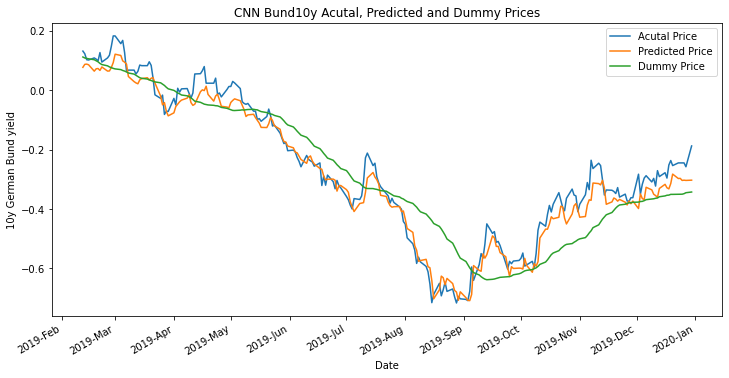

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

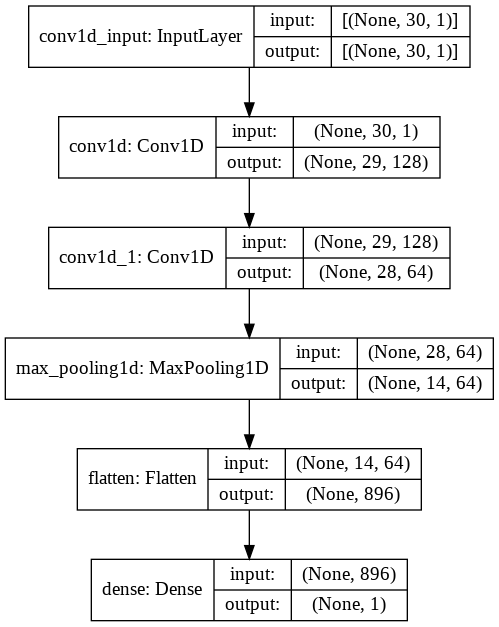

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0023283196940655023
RMSE:  0.04825266514987024
MAE:  0.038395223761442984
Dummy MSE:  0.01192499274023522
Dummy RMSE:  0.10920161509902324
Dummy MAE:  0.0887186459104488


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_Bund10y/assets
